In [56]:
#コードに関する説明
#①授業内で説明されたコードをもとにまず基本的な関数、パラメータを定義する。
#②資産所得課税、補助金が0の場合を基本形として、それぞれの問いに合わせてパラメータを再定義し、計算、可視化するように定めた。

In [57]:
#関数の定義
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space


In [58]:
# パラメータの定義
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.98, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.6, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    alpha = 0.25,
    delta = 0.03,
    tau_k = 0,
    T =0,
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta
    param['tau_k'] = tau_k
    param['T'] = T
    return param


In [59]:
#効用最適化のための関数の定義
def solve_household(param, r, w):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    T  = param['T']
    tau_k = param['tau_k']
    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + (1-tau_k)*r)*a[ia] - a[iap]+T
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 +(1-tau_k)* r)*a[ia] - aplus[ia, ih]+T

    return aplus, iaplus, c


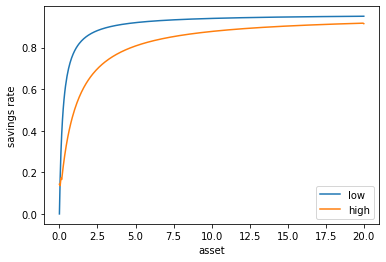

In [60]:
#問１　賃金が異なる場合の資産ごとの貯蓄率（計算と可視化）
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar(T=0) # parameters
decisions = solve_household(param, r, w) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()

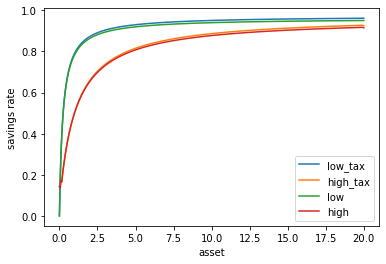

In [61]:
#問2　資産所得課税(tau_k = 0.3の場合)
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage
param = setPar(tau_k = 0.3) # parameters
decisions_2 = solve_household(param, r, w) # HH problem
aplus_2 = decisions_2[0]
c_2= decisions_2[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a_2 = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a_2, aplus_2[:, 0]/(c_2[:, 0] + aplus_2[:, 0]), label='low_tax')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a_2, aplus_2[:, 1]/(c_2[:, 1] + aplus_2[:, 1]), label='high_tax')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()


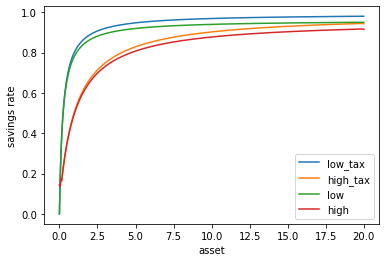

In [62]:
#問2　資産所得課税(tau_k = 0.8の場合)
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage
param = setPar(tau_k = 0.8) # parameters
decisions_3 = solve_household(param, r, w) # HH problem
aplus_3 = decisions_3[0]
c_3= decisions_3[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a_3 = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a_3, aplus_3[:, 0]/(c_3[:, 0] + aplus_3[:, 0]), label='low_tax')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a_3, aplus_3[:, 1]/(c_3[:, 1] + aplus_3[:, 1]), label='high_tax')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()


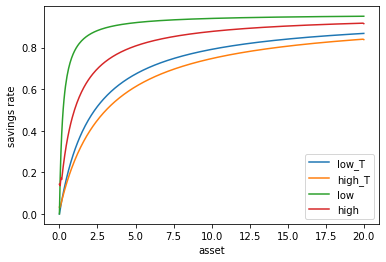

In [63]:
#問3　補助金を含めた場合
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage
param = setPar(T=1) # parameters
decisions_4 = solve_household(param, r, w) # HH problem
aplus_4 = decisions_4[0]
c_4= decisions_4[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a_4 = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a_4, aplus_4[:, 0]/(c_4[:, 0] + aplus_4[:, 0]+T), label='low_T')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a_4, aplus_4[:, 1]/(c_4[:, 1] + aplus_4[:, 1]+T), label='high_T')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()


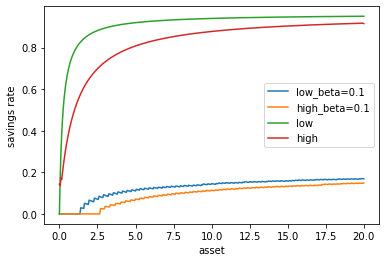

In [64]:
#問4　主観割引率が異なる場合
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage
param = setPar(beta=0.1) # parameters
decisions_5 = solve_household(param, r, w) # HH problem
aplus_5 = decisions_5[0]
c_5= decisions_5[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a_5 = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a_5, aplus_5[:, 0]/(c_5[:, 0] + aplus_5[:, 0]), label='low_beta=0.1')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a_5, aplus_5[:, 1]/(c_5[:, 1] + aplus_5[:, 1]), label='high_beta=0.1')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()
